<a href="https://colab.research.google.com/github/artemkush1/ML_test_all_models_on_pulsar/blob/master/main_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cd '/content/drive/My Drive/Colab Notebooks/pulsar_prediction'

In [0]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import *
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from tqdm import tqdm

PATH = '/content/drive/My Drive/Colab Notebooks/pulsar_prediction/'

# Load and research data

## Load and show

In [0]:
df = pd.read_csv(PATH + 'pulsar_stars.csv')
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [0]:
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [0]:
df = df.fillna(0)
#print(df)
#df = df.drop([' Standard deviation of the integrated profile', ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve'], axis=1)
df

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


## Prepare data for traning

In [290]:
scaleCoder = StandardScaler()
X = df.values[:, :-1]
y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
X_norm = scaleCoder.fit_transform(df.values[:, :-1])
y_norm = y
X_norm_train, X_norm_test,\
y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.2,
                                             random_state=42)
print(X_train.shape, X_test.shape)

(14318, 8) (3580, 8)


In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
rfe = RFE(log_reg, 5)
fit = rfe.fit(X_norm_train, y_norm_train)
print("Num Features:", fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

Num Features: 5
Selected Features: [ True False  True  True  True  True False False]
Feature Ranking: [1 4 1 1 1 1 3 2]


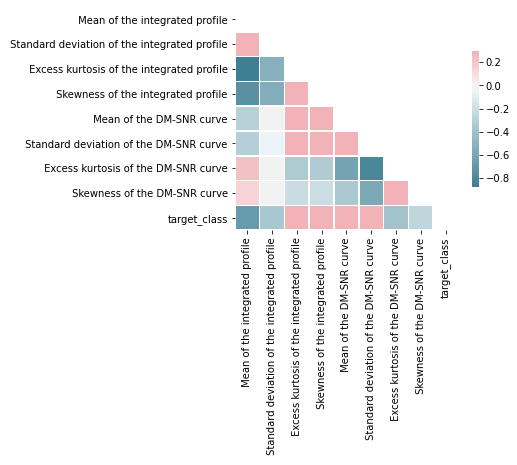

In [0]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, mask=mask,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

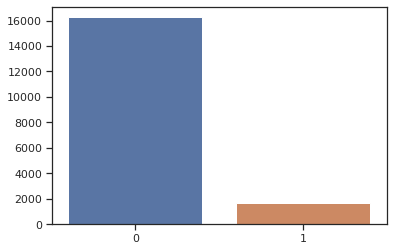

In [291]:
target_class = df.columns[-1]
sns.barplot(y=[len(df[df[target_class].astype(int) == 0]), len(df[df[target_class].astype(int) == 1])], x=[0, 1])
#df.target_class.hist()

<Figure size 432x288 with 0 Axes>

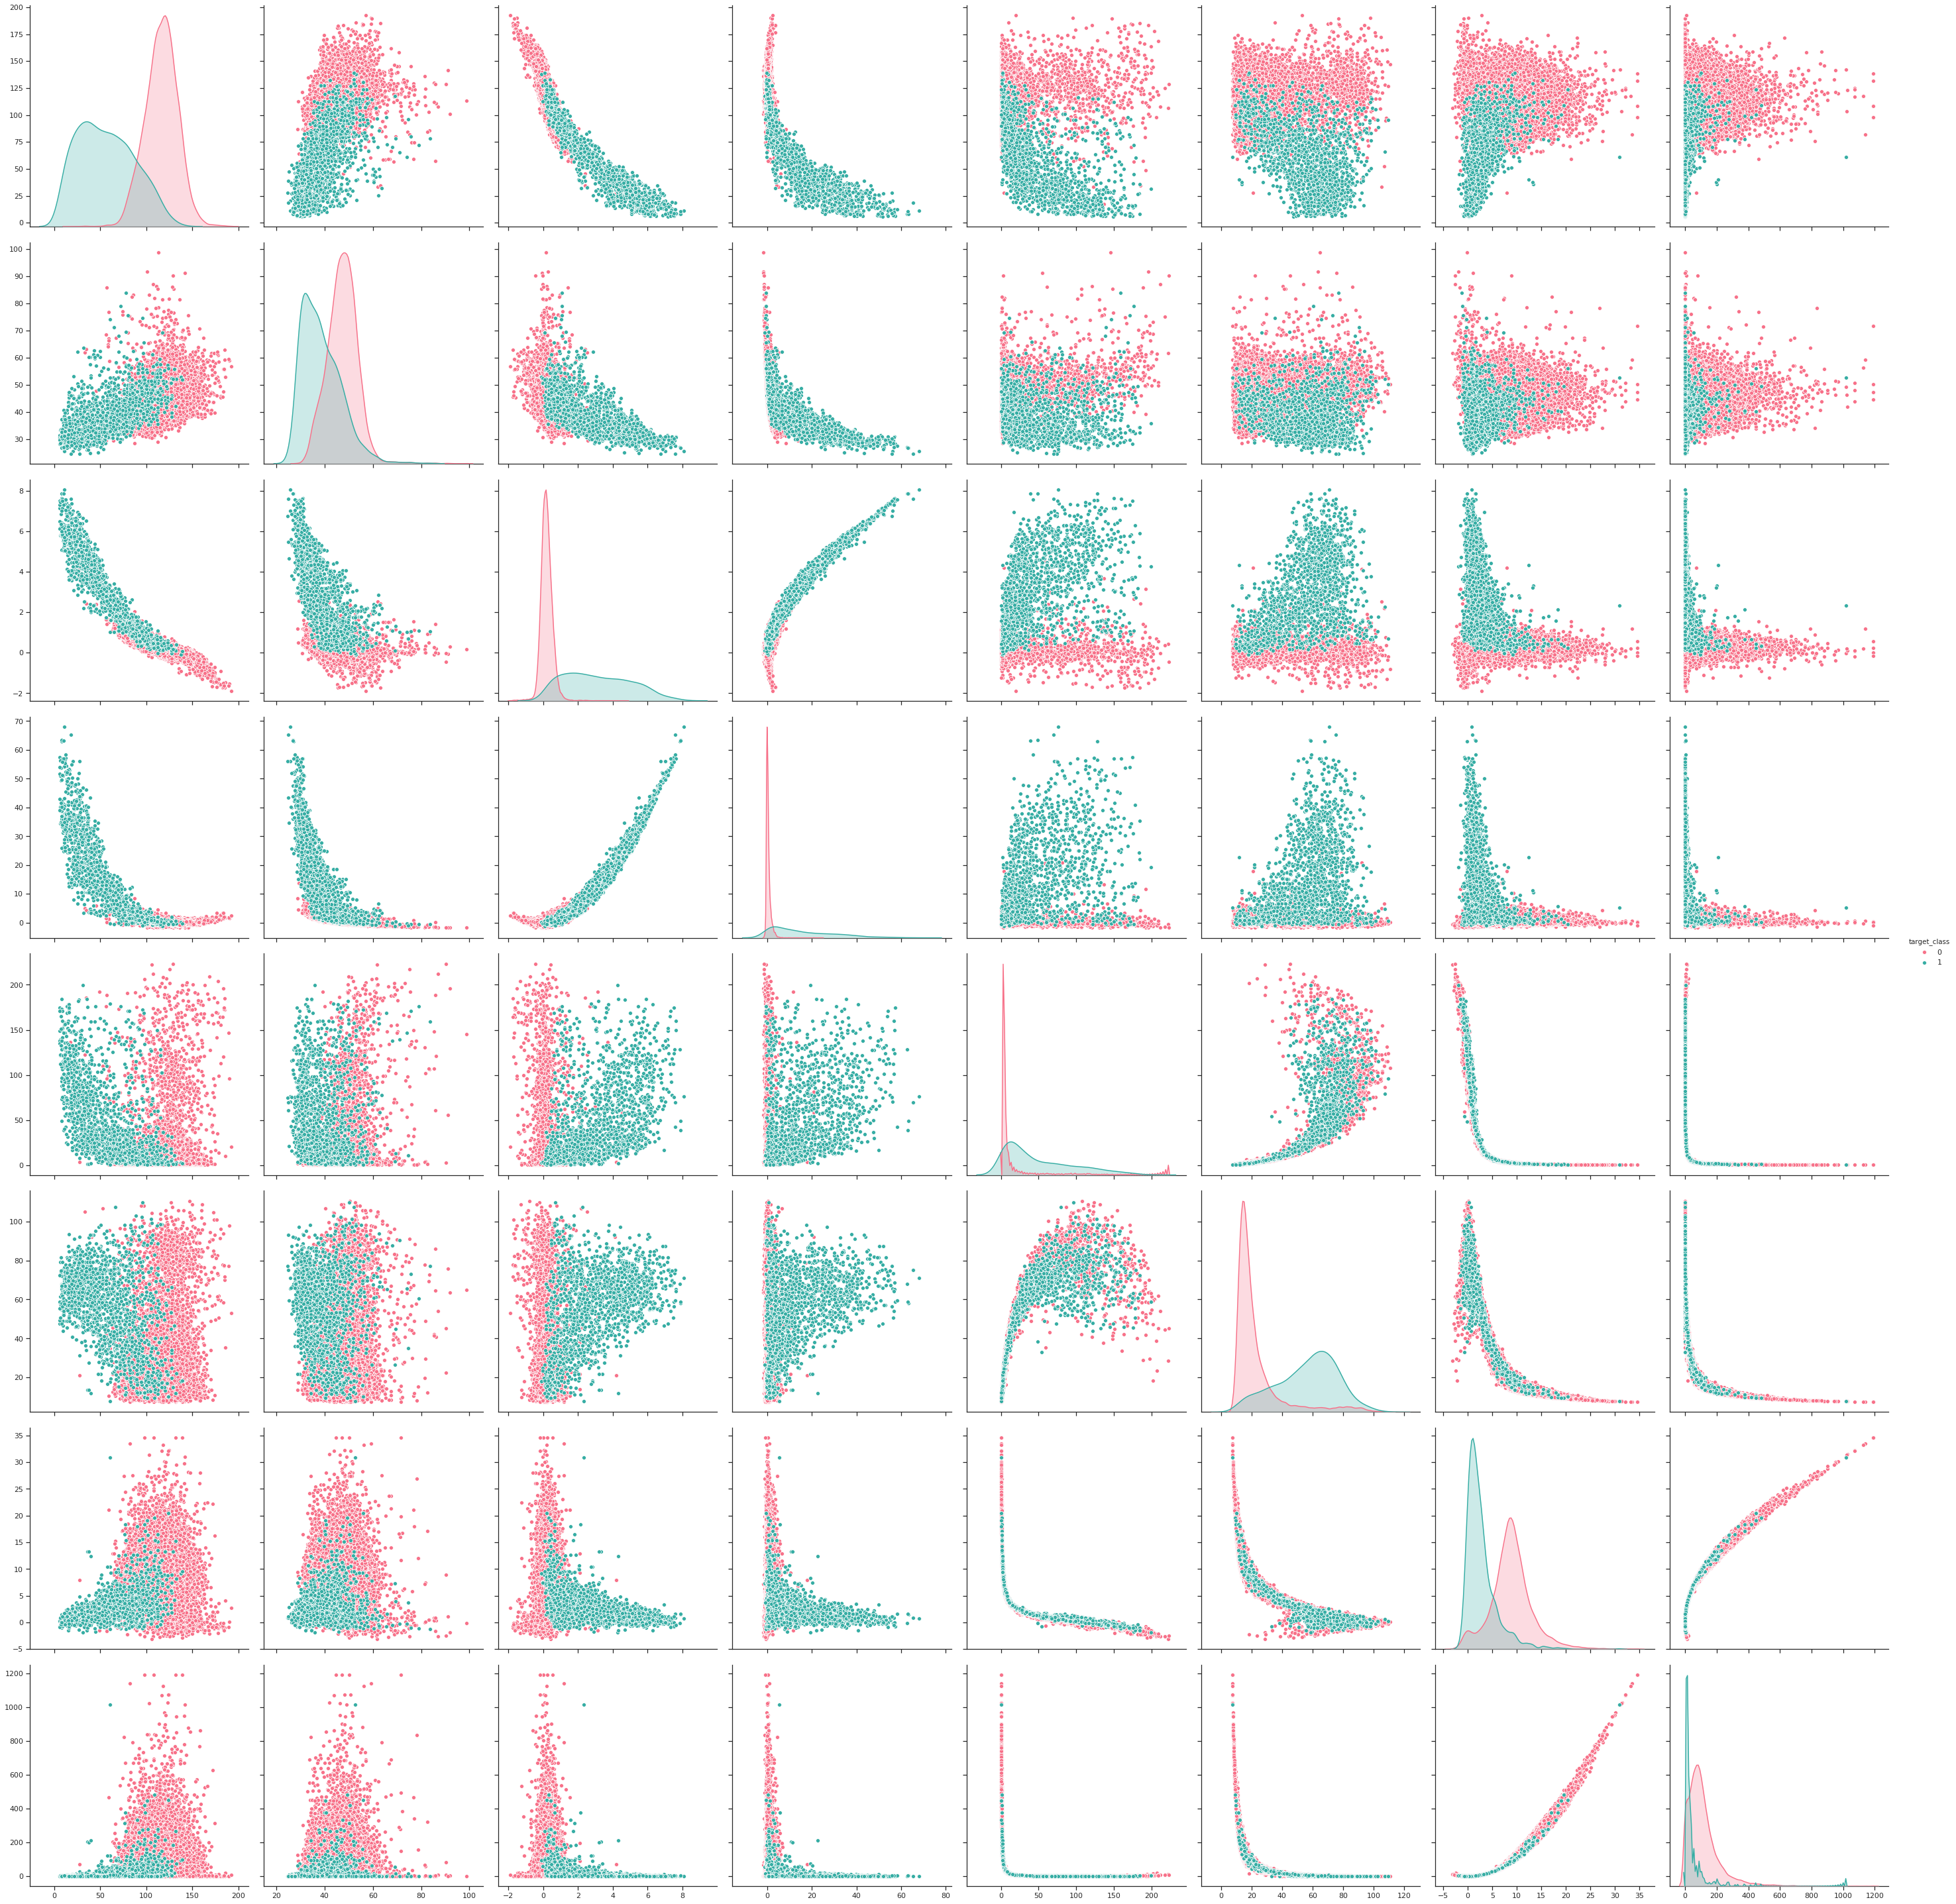

In [0]:
target_class = df.columns[-1]
sns.set(style="ticks", color_codes=True)
plt.figure()
p = sns.pairplot(df, hue=target_class, palette="husl",
                 height=5, corner=False)  # kind="reg"
p.set(xlabel='', ylabel='')
plt.show()

## Some extra functions

In [0]:
res = {}

def find_best_model(parameters, m, show=False):
    m = GridSearchCV(m, parameters, scoring='f1')
    m.fit(X_train, y_train)
    name = list(parameters.keys())[0]
    if show is True:
        print('Best param:', m.best_params_[name])
        plt.plot([m.cv_results_['params'][i][name] for i in range(len(m.cv_results_['params']))],
                m.cv_results_['mean_test_score'])
        plt.show()
    return m

kfold = StratifiedKFold(n_splits=8)
def cross_val(m, name):
    m.fit(X_norm_train, y_norm_train)
    y_pred = m.predict(X_norm_test)
    try:
        y_pred_proba = m.predict_proba(X_norm_test)
        auc_score_single = roc_auc_score(y_norm_test, y_pred_proba[:,1])
    except:
        auc_score_single = None
    acc_score_single = accuracy_score(y_norm_test, y_pred)
    f_score_single = f1_score(y_norm_test, y_pred)
    acc_score = []
    auc_score = []
    f_score = []
    for train_idx, test_idx in tqdm(kfold.split(X_norm, y_norm)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        try:
            y_pred_proba = m.predict_proba(X_test)
            auc_score.append(roc_auc_score(y_test, y_pred_proba[:,1]))
        except:
            auc_score.append(0)
        acc_score.append(accuracy_score(y_test, y_pred))
        f_score.append(f1_score(y_test, y_pred))
    res[name] = [np.asarray(acc_score).mean(), np.asarray(f_score).mean(), np.asarray(auc_score).mean()]
    data = pd.DataFrame(data={
        'metric': ['acc', 'f1', 'auc_roc'],
        'single_model': [acc_score_single, f_score_single, auc_score_single],
        'cross_val': res[name]
    })
    return data

def single_model(m, name):
    m.fit(X_norm_train, y_norm_train)
    y_pred = m.predict(X_norm_test)
    try:
        y_pred_proba = m.predict_proba(X_norm_test)
        auc_score_single = roc_auc_score(y_norm_test, y_pred_proba[:,1])
    except:
        auc_score_single = None
    acc_score_single = accuracy_score(y_norm_test, y_pred)
    f_score_single = f1_score(y_norm_test, y_pred)
    res[name] = [acc_score_single, f_score_single, auc_score_single]
    data = pd.DataFrame(data={
        'metric': ['acc', 'f1', 'auc_roc'],
        'single_model': [acc_score_single, f_score_single, auc_score_single],
    })
    return data

# Model 1 - LDA

In [263]:
from sklearn.discriminant_analysis import *
lda = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001)

cross_val(lda, 'LDA')



0it [00:00, ?it/s]
3it [00:00, 24.57it/s]
8it [00:00, 24.90it/s]


,metric,single_model,cross_val
0,acc,0.974302,0.974914
1,f1,0.841924,0.848155
2,auc_roc,0.973486,0.974889


# Model 2 - DummyClassifier

In [264]:
from sklearn.dummy import *
dc = DummyClassifier(strategy='most_frequent', random_state=None, constant=None)

cross_val(dc, 'DummyClassifier')


8it [00:00, 147.08it/s]


,metric,single_model,cross_val
0,acc,0.910335,0.908426
1,f1,0.000000,0.000000
2,auc_roc,0.500000,0.500000


# Model 3 - Linear

In [0]:
from sklearn.linear_model import *

sgd = SGDClassifier(loss='log')
cross_val(sgd, 'SGDClassifier')

In [266]:
rc = RidgeClassifier(alpha=1.0)
cross_val(rc, 'RidgeClassifier')


0it [00:00, ?it/s]
8it [00:00, 60.48it/s]


,metric,single_model,cross_val
0,acc,0.970391,0.970947
1,f1,0.809353,0.816071
2,auc_roc,NaN,0.000000


In [267]:
pca = PassiveAggressiveClassifier(C=1.0)

cross_val(pca, 'PassiveAggressiveClassifier')


0it [00:00, ?it/s]
8it [00:00, 37.68it/s]


,metric,single_model,cross_val
0,acc,0.977654,0.965471
1,f1,0.875389,0.811807
2,auc_roc,NaN,0.000000


In [268]:
lg = LogisticRegression(max_iter=1000)
cross_val(lg, 'LogReg')


0it [00:00, ?it/s]
1it [00:00,  2.21it/s]
2it [00:00,  2.15it/s]
3it [00:01,  2.12it/s]
4it [00:01,  2.19it/s]
5it [00:02,  2.11it/s]
6it [00:02,  2.21it/s]
7it [00:03,  2.20it/s]
8it [00:03,  2.17it/s]


,metric,single_model,cross_val
0,acc,0.978771,0.978769
1,f1,0.873754,0.875712
2,auc_roc,0.974463,0.975795


# Model 4 - Ensembles

In [269]:
from sklearn.ensemble import *
rfc = RandomForestClassifier(n_estimators=100)
single_model(gbc, 'RandomForestClassifier')

,metric,single_model
0,acc,0.981844
1,f1,0.893964
2,auc_roc,0.974305


In [270]:
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.02,
    n_estimators=100, subsample=1.0, criterion='friedman_mse',
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_depth=4, min_impurity_decrease=0.0, min_impurity_split=None, init=None,
    random_state=1)
single_model(gbc, 'GradientBoostingCl')


,metric,single_model
0,acc,0.981844
1,f1,0.893964
2,auc_roc,0.974305


# Model 5 - KNN

Best param: 9


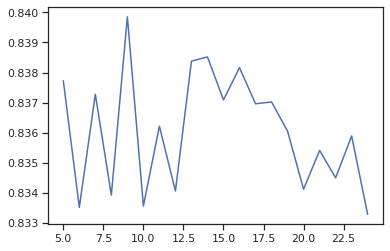


0it [00:00, ?it/s]
1it [00:12, 12.71s/it]
2it [00:25, 12.77s/it]
3it [00:38, 12.76s/it]
4it [00:51, 12.74s/it]
5it [01:03, 12.72s/it]
6it [01:16, 12.72s/it]
7it [01:29, 12.71s/it]
8it [01:41, 12.75s/it]


,metric,single_model,cross_val
0,acc,0.979609,0.972455
1,f1,0.879736,0.836741
2,auc_roc,0.964594,0.942590


In [257]:
from sklearn.neighbors import *

parameters = {'n_neighbors': [x for x in range(5, 25)]}

knn = KNeighborsClassifier()
knn = find_best_model(parameters=parameters, m=knn, show=True)
cross_val(knn, "KNeighborsCl")

In [0]:
knn = RadiusNeighborsClassifier(radius=80)
cross_val(knn, "RadNeighborsCl")

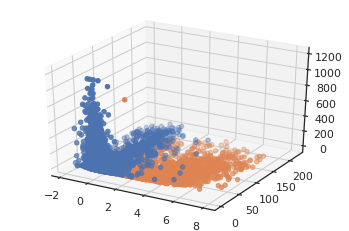

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(2):
    df_tmp = df[df['target_class'] == i]
    ax.scatter(df_tmp.iloc[:, 2], df_tmp.iloc[:, 4], df_tmp.iloc[:, -2])

plt.show()

# Model 6 - Naive Bayes

In [258]:
from sklearn.naive_bayes import *

gnb = GaussianNB(priors=None, var_smoothing=1e-09)
cross_val(gnb, "GaussianNB")


8it [00:00, 103.62it/s]


,metric,single_model,cross_val
0,acc,0.947486,0.944629
1,f1,0.745946,0.741413
2,auc_roc,0.958404,0.954985


# Model 7 - XGBoost & LGBM

    metric  single_model
0      acc      0.981564
1       f1      0.892157
2  auc_roc      0.978377


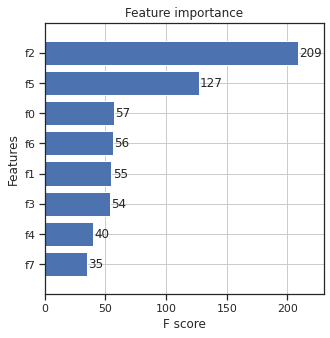

In [259]:
import xgboost as xgb

xgbm = xgb.XGBClassifier()

print(single_model(xgbm, 'XGBoost'))

fig, ax = plt.subplots(figsize=(5,5))
xgb.plot_importance(xgbm, max_num_features=None, height=0.8, ax=ax)
plt.show()

    metric  single_model
0      acc      0.981844
1       f1      0.893964
2  auc_roc      0.978100


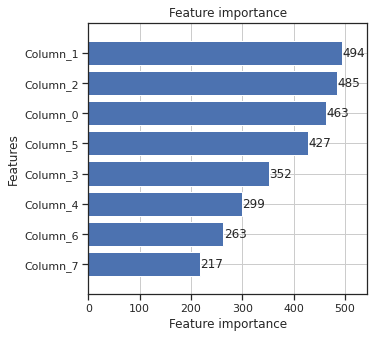

In [276]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()


print(single_model(lgbm, 'Lightgbm'))

fig, ax = plt.subplots(figsize=(5,5))
lgb.plot_importance(lgbm, max_num_features=None, height=0.8, ax=ax)
plt.show()

# Model 8 - CatBoost

In [0]:
!pip install catboost

In [260]:
from catboost import CatBoostClassifier, Pool
catb = CatBoostClassifier(iterations=None,
    learning_rate=None, depth=None, l2_leaf_reg=None,
    model_size_reg=None, rsm=None, loss_function=None,
    border_count=None, feature_border_type=None,
    per_float_feature_quantization=None, input_borders=None,
    output_borders=None, fold_permutation_block=None,
    od_pval=None, od_wait=None, od_type=None, nan_mode=None,
    counter_calc_method=None, leaf_estimation_iterations=None,
    leaf_estimation_method=None, thread_count=None,
    random_seed=None, use_best_model=None, verbose=False,
    logging_level=None, metric_period=None,
    ctr_leaf_count_limit=None, store_all_simple_ctr=None,
    max_ctr_complexity=None, has_time=None, allow_const_label=None,
    classes_count=None, class_weights=None, one_hot_max_size=None,
    random_strength=None, name=None, ignored_features=None,
    train_dir=None, custom_loss=None, custom_metric=None,
    eval_metric=None, bagging_temperature=None, save_snapshot=None,
    snapshot_file=None, snapshot_interval=None,
    fold_len_multiplier=None, used_ram_limit=None, gpu_ram_part=None,
    allow_writing_files=None, final_ctr_computation_mode=None,
    approx_on_full_history=None, boosting_type='Ordered',
    simple_ctr=None, combinations_ctr=None, per_feature_ctr=None,
    task_type=None, device_config=None, devices=None,
    bootstrap_type=None, subsample=None, sampling_unit=None,
    dev_score_calc_obj_block_size=None, max_depth=None, n_estimators=None,
    num_boost_round=None, num_trees=None, colsample_bylevel=None,
    random_state=None, reg_lambda=None, objective=None, eta=None,
    max_bin=None, scale_pos_weight=None, gpu_cat_features_storage=None,
    data_partition=None, metadata=None, early_stopping_rounds=None,
    cat_features=None,grow_policy=None, min_data_in_leaf=None,
    min_child_samples=None, max_leaves=None, num_leaves=None,
    score_function=None, leaf_estimation_backtracking=None,
    ctr_history_unit=None, monotone_constraints=None,
    model_shrink_rate=None, model_shrink_mode=None,
    langevin=None, diffusion_temperature=None, boost_from_average=None,
    text_features=None, tokenizers=None, dictionaries=None,
    feature_calcers=None, text_processing=None)


#catb.fit(X_train, y_train, plot=True)

print(single_model(catb, 'CatBoost'))

    metric  single_model
0      acc      0.982961
1       f1      0.900813
2  auc_roc      0.978718


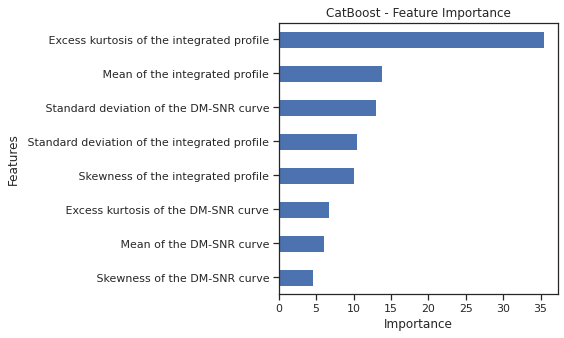

In [181]:
fea_imp = pd.DataFrame({'imp': catb.feature_importances_, 'col': df.columns[:-1]})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(5, 5), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

# Model 9 - Neuro

In [224]:
import tensorflow as tf
from keras import backend as K
import os
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, PReLU
from keras.optimizers import Adam

"""
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
"""

'''
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
'''

'''
def roc_auc_score(y_true, y_pred):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):
        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))
        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)
        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.2
        p = 3
        difference = tf.zeros_like(pos * neg) + pos - neg - gamma
        masked = tf.boolean_mask(difference, difference < 0.0)
    return tf.reduce_sum(tf.pow(-masked, p))
'''

'\ndef roc_auc_score(y_true, y_pred):\n    """ ROC AUC Score.\n    Approximates the Area Under Curve score, using approximation based on\n    the Wilcoxon-Mann-Whitney U statistic.\n    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).\n    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.\n    Measures overall performance for a full range of threshold levels.\n    Arguments:\n        y_pred: `Tensor`. Predicted values.\n        y_true: `Tensor` . Targets (labels), a probability distribution.\n    """\n    with tf.name_scope("RocAucScore"):\n        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))\n        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))\n        pos = tf.expand_dims(pos, 0)\n        neg = tf.expand_dims(neg, 1)\n        # original paper suggests performance is robust to exact parameter choice\n        gamma = 0.2\n        p = 3\n        difference = tf.zeros_like(pos * neg) + pos - neg - gamma\n    

In [183]:
import os
def create_model():
    return keras.Sequential(
        [
         Conv1D(filters=64, kernel_size=2, input_shape=(8, 1)),
         PReLU(),
         MaxPool1D(pool_size=2),
         Dropout(0.2),
         Conv1D(filters=32, kernel_size=2),
         PReLU(),
         MaxPool1D(pool_size=2),
         #tf.keras.layers.Dropout(0.2),
         #tf.keras.layers.Dense(32, activation='relu'),
         #tf.keras.layers.Dropout(0.1),
         #tf.keras.layers.Dense(16, activation='relu'),
         #tf.keras.layers.Dropout(0.1),
         Dropout(0.2),
         Flatten(),
         Dense(32, activation='relu'),
         Dropout(0.2),
         Dense(1, activation='sigmoid')])

# with strategy.scope():
model = create_model()
print(model.summary())
model.compile(optimizer=Adam(learning_rate=0.0007),
                loss='mse',
                metrics=['acc'])



X_train_ = X_norm_train.reshape(-1, 8, 1)
y_train_ = y_norm_train.reshape(-1, 1)
X_test_ = X_norm_test.reshape(-1, 8, 1)
y_test_ = y_norm_test.reshape(-1, 1)
"""
history = model.fit(X_train_, y_train_,
          epochs=300, batch_size=256, callbacks=[ModelCheckpoint(PATH + 'weights', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)],
          validation_data=(X_test_, y_test_),
          verbose=1)"""
model.load_weights(PATH + 'weights')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7, 64)             192       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 7, 64)             448       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 32)             4128      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 2, 32)             64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 32)            

In [261]:
def ploting():
    # print(history.history.keys())
    ac = []
    for i in history.history.keys():
        ac.append(i)
    loss = history.history[ac[2]]
    val_loss = history.history[ac[0]]
    acc = history.history[ac[3]]
    val_acc = history.history[ac[1]]
    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss', color='r')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc', color='r')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    for ax in fig.axes:
        ax.grid(True)
    plt.savefig(PATH + 'graph')
    plt.show()


def single_model_neuro(m, name):
    y_pred = np.round(m.predict(X_test_))
    y_pred_proba = m.predict_proba(X_test_)
    try:
        y_pred_proba = m.predict_proba(X_test_)
        auc_score_single = roc_auc_score(y_test_.reshape(-1), y_pred_proba.reshape(-1))
    except:
        auc_score_single = None
    acc_score_single = accuracy_score(y_test_.reshape(-1), y_pred.reshape(-1))
    f_score_single = f1_score(y_test_.reshape(-1), y_pred.reshape(-1))
    res[name] = [acc_score_single, f_score_single, auc_score_single]
    data = pd.DataFrame(data={
        'metric': ['acc', 'f1', 'auc_roc'],
        'single_model': [acc_score_single, f_score_single, auc_score_single],
    })
    return data


single_model_neuro(model, "NeuroCNN")

,metric,single_model
0,acc,0.983240
1,f1,0.904459
2,auc_roc,0.976494


# Rating

In [0]:
res

In [0]:
import operator
sort_dict = sorted(res.items(), key=operator.itemgetter(1), reverse=True)
sort_dict

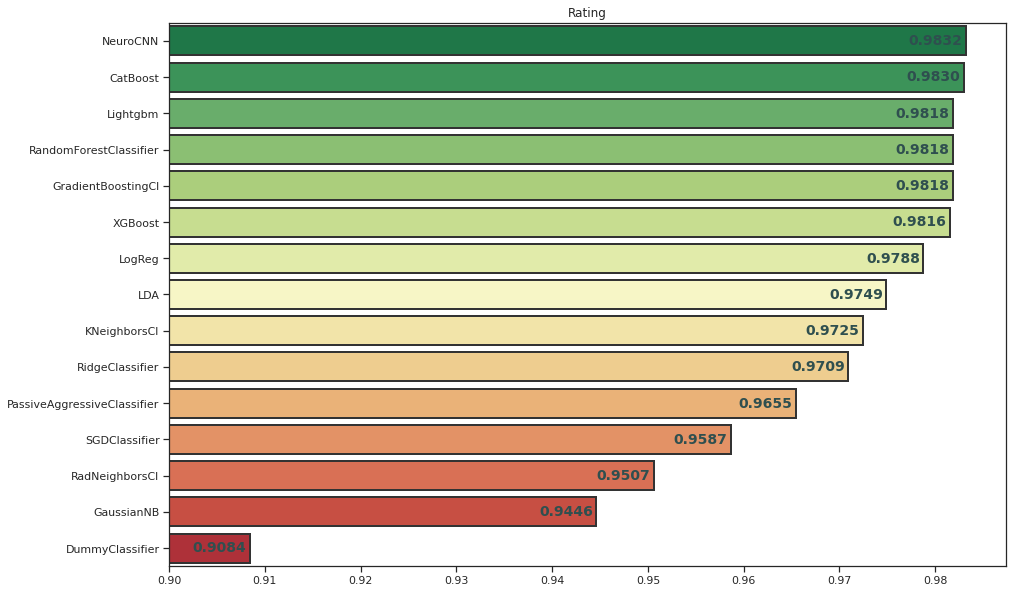

In [305]:
# visualization

def visualize(column=0):
    y = [x[1][column] for x in sort_dict]
    labels = [x[0] for x in sort_dict]
    shift = 0.9
    plt.figure(figsize=(15, 10))
    graph = sns.barplot(x=(np.asarray(y) - shift), y=labels,
                        palette=sns.color_palette("RdYlGn_r", len(y)),
                        edgecolor=".2", linewidth=2)
    plt.xticks([i / 100 for i in range(0, 9)], ["%.2f" % (i / 100 + shift) for i in range(0, 9)])
    for i, v in enumerate(y):
        graph.text(v - shift - 0.006, i + 0.105, "%.4f" % v, color='darkslategray', fontweight='bold', size=14)
    plt.title('Rating')
    plt.savefig(PATH + f'rating_models_{column}', dpi=150)
    plt.show()

visualize(0)